In [13]:
%pip install pyspark

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


# Batch SOM in Spark

### our_som2.py

In [14]:
from pyspark import SparkContext, Row, SQLContext
from pyspark.ml.linalg import Vectors
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches as patches

class SOM:
    """
    Implementation of Batch SOM
    """

    def __init__(self, net_x_dim, net_y_dim, num_features):
        self.network_dimensions = np.array([net_x_dim, net_y_dim])
        self.init_radius = min(self.network_dimensions[0], self.network_dimensions[1])
        # initialize weight vectors
        self.num_features = num_features
        self.initialize()

    def initialize(self):
        self.net = np.random.random((self.network_dimensions[0], self.network_dimensions[1], self.num_features))

The utility function for finding the distance and BMU (Eq (1) & (2)) is as follows:

In [15]:
    def find_bmu(row_t, net):
        """
            Find the best matching unit for a given vector, row_t, in the SOM
            Returns: a (bmu, bmu_idx) tuple where bmu is the high-dimensional Best Matching Unit
                     and bmu_idx is the index of this vector in the SOM
        """
        net_size = np.shape(net)
        x_size = net_size[0]
        y_size = net_size[1]
        num_features = net_size[2]
        bmu_idx = np.array([0, 0])
        # set the initial minimum distance to a huge number
        min_dist = np.iinfo(np.int).max
        # calculate the high-dimensional distance between each neuron and the input
        # for (k = 1,..., K)
        for x in range(x_size):
            for y in range(y_size):
                weight_k = net[x, y, :].reshape(1, num_features)
                # compute distances dk using Eq. (2)
                sq_dist = np.sum((weight_k - row_t) ** 2)
                # compute winning node c using Eq. (3)
                if sq_dist < min_dist:
                    min_dist = sq_dist
                    bmu_idx = np.array([x, y])
        # get vector corresponding to bmu_idx
        bmu = net[bmu_idx[0], bmu_idx[1], :].reshape(1, num_features)
        return bmu, bmu_idx

Similarly, the implementation of neighborhood function (Eq (4)) is as follows:

In [16]:
def train(self, df, num_epochs, resetWeights=False):
        """

        :param df: input dataframe for training with "features" column
        :param num_epochs: for how many epochs should the dataframe be trained
        :param resetWeights: should the weights be randomized for next training
        :return:
        """
        if resetWeights:
            self.initialize()
        # Making sure the radius decays from initial value comparable to the dimension of network to 1
        self.time_constant = num_epochs / np.log(self.init_radius)
        # visualization
        if self.num_features == 3:
            fig = plt.figure()
        else:
            fig = None
        # using spark's cache feature as the algorithm is iterative
        rdd = df.rdd.cache()
        # getting sparkContext
        sc = SparkContext.getOrCreate()
        # for (epoch = 1,..., Nepochs)
        for i in range(1, num_epochs + 1):
            # interpolate new value for  \sigma(t)
            radius = self.decay_radius(i)
            # visualization
            vis_interval = int(num_epochs/10)
            if i % vis_interval == 0:
                if fig is not None:
                    self.show_plot(fig, i/vis_interval, i)
                print("SOM training epoches %d" % i)
                print("neighborhood radius ", radius)
                # print(self.net)
                print("-------------------------------------")
            # using spark broadcast to send initial/updated net to all workers
            broadcast_net = sc.broadcast(self.net)
            # a wrapper function to prevent serialization of whole class
            def train_partition_wrapper(x_size, y_size, num_features):

                def train_partition(partition_rows):
                    # getting broadcasted net w_{k}(t_0) in each worker 
                    partition_net = broadcast_net.value
                    # Initializing numerator and denominator of Eq (1) to zero to accumulate local sum
                    part_sum_numerator = np.array(np.zeros([x_size, y_size, num_features]))
                    part_sum_denominator = np.array(np.zeros([x_size, y_size, 1]))

                    for row_t in partition_rows:
                        # find bmu using utility function
                        bmu, bmu_idx = find_bmu(row_t['features'], partition_net)
                        
                        for x in range(x_size):
                            for y in range(y_size):
                                # find distance between each neuron and BMU
                                w_dist = np.sum((np.array([x, y]) - bmu_idx) ** 2)
                                # if the distance is within the current neighbourhood radius
                                if w_dist <= radius ** 2:
                                    # calculate influence using eq (4)
                                    influence = calculate_influence(w_dist, radius)
                                    # accumulate local sum for denominator and numerator
                                    part_sum_denominator[x, y, :] = part_sum_denominator[x, y, :] + influence
                                    new_w = influence * row_t['features']
                                    part_sum_numerator[x, y, :] = part_sum_numerator[x, y, :] + new_w
                    yield Row(num=part_sum_numerator, den=part_sum_denominator)

                return train_partition
            # initialize numerator and denominator for global sum to zero
            epoch_sum_num = np.array(np.zeros([self.network_dimensions[0], self.network_dimensions[1], self.num_features]))
            epoch_sum_den = np.array(np.zeros([self.network_dimensions[0], self.network_dimensions[1], self.num_features]))
            part_sum_rdd = rdd.mapPartitions(train_partition_wrapper(self.network_dimensions[0], self.network_dimensions[1], self.num_features))
            # combine local sum by each task into global sum
            for row in part_sum_rdd.collect():
                epoch_sum_num += row['num']
                epoch_sum_den += row['den']
            # update the net
            self.net = epoch_sum_num/epoch_sum_den
        # visualization
        if fig is not None:
            plt.show()

def decay_radius(self, iteration):
        return self.init_radius * np.exp(-iteration / self.time_constant)

def show_plot(self, fig, position, epoch):
        # setup axes
        ax = fig.add_subplot(2, 5, position, aspect="equal")
        ax.set_xlim((0, self.net.shape[0] + 1))
        ax.set_ylim((0, self.net.shape[1] + 1))
        ax.set_title('Ep: %d' % epoch)

        # plot the rectangles
        for x in range(1, self.net.shape[0] + 1):
            for y in range(1, self.net.shape[1] + 1):
                ax.add_patch(patches.Rectangle((x - 0.5, y - 0.5), 1, 1,
                                               facecolor=self.net[x - 1, y - 1, :],
                                               edgecolor='none'))

The implementation of getting prediction (BMU and its coordinate) for each feature is as follows:

In [17]:
def predict(self, df):
        # find its Best Matching Unit
        column_names = df.columns

        def prediction_wrapper(net):
            def prediction_map_func(row):
                cols_map = {}
                for col in column_names:
                    cols_map[col] = row[col]
                bmu, bmu_idx = find_bmu(row['features'], net)
                cols_map["bmu"] = Vectors.dense(bmu[0])
                cols_map["bmu_idx"] = Vectors.dense(bmu_idx)
                return Row(**cols_map)
            rdd_prediction = df.rdd.map(lambda row: prediction_map_func(row))
            # getting existing sparkContext
            sc = SparkContext.getOrCreate()
            sqlContext = SQLContext(sc)
            return sqlContext.createDataFrame(rdd_prediction)
        return prediction_wrapper(self.net)

# Application Example

In [18]:
from pyspark.sql import SQLContext
# create entry points to spark
try:
    sc.stop()
except:
    pass
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
sc = SparkContext()
spark = SparkSession(sparkContext=sc)
sqlContext = SQLContext(sc)

In [19]:
## Read data
input_data = sqlContext.read.format("com.databricks.spark.csv") \
                .option("delimiter", ",") \
                .option("header", "true") \
                .option("inferSchema", "true") \
                .load("cash-crops-nepal.csv")

input_data.show(10)

+-------+-------+-------+------+----------+-----+
|Year AD|Year BS|   Crop|  Area|Production|Yield|
+-------+-------+-------+------+----------+-----+
|1984/85|2041/42|OILSEED|127820|     84030|  657|
|1985/86|2042/43|OILSEED|137920|     78390|  568|
|1986/87|2043/44|OILSEED|142890|     82500|  577|
|1987/88|2044/45|OILSEED|151490|     94370|  623|
|1988/89|2045/46|OILSEED|154860|     99190|  641|
|1989/90|2046/47|OILSEED|153660|     98060|  638|
|1990/91|2047/48|OILSEED|156310|     92140|  589|
|1991/92|2048/49|OILSEED|154570|     87840|  568|
|1992/93|2049/50|OILSEED|165240|     93690|  567|
|1993/94|2050/51|OILSEED|177486|    107535|  606|
+-------+-------+-------+------+----------+-----+
only showing top 10 rows



In [20]:
# shuffling data and repartitioning to manage level of parallelism
input_data = input_data.repartition(8)
input_data.show(10)

+---------+-------+---------+------+----------+-----+
|  Year AD|Year BS|     Crop|  Area|Production|Yield|
+---------+-------+---------+------+----------+-----+
|  1993/94|2050/51|SUGARCANE| 37785|   1293092|34222|
|  1997/98|2054/55|     JUTE| 12265|     15545| 1267|
|  1994/95|2051/52|   POTATO| 97634|    838932| 8593|
|  1988/89|2045/46|  TOBACCO|  7300|      5380|  737|
|  1986/87|2043/44|  OILSEED|142890|     82500|  577|
|2002/2003|2059/60|  OILSEED|186720|    124931|  669|
|  1992/93|2049/50|  OILSEED|165240|     93690|  567|
|  1993/94|2050/51|  OILSEED|177486|    107535|  606|
|1999/2000|2056/57|  OILSEED|189629|    122751|  647|
|  1998/99|2055/56|  TOBACCO|  4422|      3911|  884|
+---------+-------+---------+------+----------+-----+
only showing top 10 rows



In [21]:
# selecting features from dataframe
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(
    inputCols = ["Area", "Production", "Yield"],
    outputCol = "raw_features"
)
input_features = assembler.transform(input_data)
input_features.show(10)

+---------+-------+---------+------+----------+-----+--------------------+
|  Year AD|Year BS|     Crop|  Area|Production|Yield|        raw_features|
+---------+-------+---------+------+----------+-----+--------------------+
|  1993/94|2050/51|SUGARCANE| 37785|   1293092|34222|[37785.0,1293092....|
|  1997/98|2054/55|     JUTE| 12265|     15545| 1267|[12265.0,15545.0,...|
|  1994/95|2051/52|   POTATO| 97634|    838932| 8593|[97634.0,838932.0...|
|  1988/89|2045/46|  TOBACCO|  7300|      5380|  737|[7300.0,5380.0,73...|
|  1986/87|2043/44|  OILSEED|142890|     82500|  577|[142890.0,82500.0...|
|2002/2003|2059/60|  OILSEED|186720|    124931|  669|[186720.0,124931....|
|  1992/93|2049/50|  OILSEED|165240|     93690|  567|[165240.0,93690.0...|
|  1993/94|2050/51|  OILSEED|177486|    107535|  606|[177486.0,107535....|
|1999/2000|2056/57|  OILSEED|189629|    122751|  647|[189629.0,122751....|
|  1998/99|2055/56|  TOBACCO|  4422|      3911|  884|[4422.0,3911.0,88...|
+---------+-------+------

MaxAbsScaler from Spark’s machine learning library is used to normalize the features between 0 to 1 while preserving the original distance as we are later using Euclidean distance.

In [22]:
# MaxAbsScaler is used to preserve the original features and distance as we will later use Euclidean distance
from pyspark.ml.feature import MaxAbsScaler
scaler = MaxAbsScaler(inputCol="raw_features", outputCol="features")
scalerModel = scaler.fit(input_features)
scaledData = scalerModel.transform(input_features).drop("raw_features")
scaledData.show(10)

+---------+-------+---------+------+----------+-----+--------------------+
|  Year AD|Year BS|     Crop|  Area|Production|Yield|            features|
+---------+-------+---------+------+----------+-----+--------------------+
|  1993/94|2050/51|SUGARCANE| 37785|   1293092|34222|[0.19842040865624...|
|  1997/98|2054/55|     JUTE| 12265|     15545| 1267|[0.06440720688550...|
|  1994/95|2051/52|   POTATO| 97634|    838932| 8593|[0.51270552279327...|
|  1988/89|2045/46|  TOBACCO|  7300|      5380|  737|[0.03833449737172...|
|  1986/87|2043/44|  OILSEED|142890|     82500|  577|[0.75035840129392...|
|2002/2003|2059/60|  OILSEED|186720|    124931|  669|[0.98052292455455...|
|  1992/93|2049/50|  OILSEED|165240|     93690|  567|[0.86772497886351...|
|  1993/94|2050/51|  OILSEED|177486|    107535|  606|[0.93203241102983...|
|1999/2000|2056/57|  OILSEED|189629|    122751|  647|[0.99579895919213...|
|  1998/99|2055/56|  TOBACCO|  4422|      3911|  884|[0.02322125306544...|
+---------+-------+------

## Training SOM

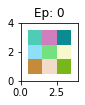

In [23]:
from our_som2 import SOM
from matplotlib import pyplot as plt
from matplotlib import patches as patches
som = SOM(3,3,3)
init_fig = plt.figure()
som.show_plot(init_fig, 1, 0)
plt.show()

In [24]:
## no learning rate needed
som.train(scaledData, 200)

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 3 in stage 20.0 failed 1 times, most recent failure: Lost task 3.0 in stage 20.0 (TID 23) (staff-3266.wireless.ua.pt executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/Users/eugenio/Library/Python/3.8/lib/python/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 481, in main
    raise RuntimeError(("Python in worker has different version %s than that in " +
RuntimeError: Python in worker has different version 3.9 than that in driver 3.8, PySpark cannot run with different minor versions. Please check environment variables PYSPARK_PYTHON and PYSPARK_DRIVER_PYTHON are correctly set.

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:545)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:703)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:685)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:498)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:366)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:364)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:358)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:358)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:345)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:339)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.rdd.RDD.$anonfun$collect$2(RDD.scala:1030)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2254)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:506)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1462)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:509)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2403)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2352)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2351)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2351)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1109)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1109)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1109)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2591)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2533)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2522)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:898)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2214)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2235)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2254)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2279)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1030)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1029)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:180)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/Users/eugenio/Library/Python/3.8/lib/python/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 481, in main
    raise RuntimeError(("Python in worker has different version %s than that in " +
RuntimeError: Python in worker has different version 3.9 than that in driver 3.8, PySpark cannot run with different minor versions. Please check environment variables PYSPARK_PYTHON and PYSPARK_DRIVER_PYTHON are correctly set.

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:545)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:703)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:685)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:498)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:366)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:364)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:358)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:358)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:345)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:339)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.rdd.RDD.$anonfun$collect$2(RDD.scala:1030)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2254)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:506)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1462)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:509)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


<Figure size 432x288 with 0 Axes>

The output prompt above shows the expected nature of neighborhood radius decay. Also, the visualization shows that similar colors are neighbors and clusters are developed similar to previous post.

## Prediction for each input

In [25]:
prediction = som.predict(scaledData)
prediction.show()

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.runJob.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 22.0 failed 1 times, most recent failure: Lost task 0.0 in stage 22.0 (TID 28) (staff-3266.wireless.ua.pt executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/Users/eugenio/Library/Python/3.8/lib/python/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 481, in main
    raise RuntimeError(("Python in worker has different version %s than that in " +
RuntimeError: Python in worker has different version 3.9 than that in driver 3.8, PySpark cannot run with different minor versions. Please check environment variables PYSPARK_PYTHON and PYSPARK_DRIVER_PYTHON are correctly set.

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:545)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:703)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:685)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:498)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:366)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:364)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:358)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:358)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:345)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:339)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.api.python.PythonRDD$.$anonfun$runJob$1(PythonRDD.scala:166)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2254)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:506)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1462)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:509)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2403)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2352)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2351)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2351)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1109)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1109)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1109)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2591)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2533)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2522)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:898)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2214)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2235)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2254)
	at org.apache.spark.api.python.PythonRDD$.runJob(PythonRDD.scala:166)
	at org.apache.spark.api.python.PythonRDD.runJob(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/Users/eugenio/Library/Python/3.8/lib/python/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 481, in main
    raise RuntimeError(("Python in worker has different version %s than that in " +
RuntimeError: Python in worker has different version 3.9 than that in driver 3.8, PySpark cannot run with different minor versions. Please check environment variables PYSPARK_PYTHON and PYSPARK_DRIVER_PYTHON are correctly set.

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:545)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:703)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:685)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:498)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:366)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:364)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:358)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:358)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:345)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:339)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.api.python.PythonRDD$.$anonfun$runJob$1(PythonRDD.scala:166)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2254)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:506)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1462)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:509)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


NOTE: It is counter intuitive in Big Data ecosystem to use dataframe.collect() as all data gets into the driver node but I have used it for simplicity of visualization (for small dataset).

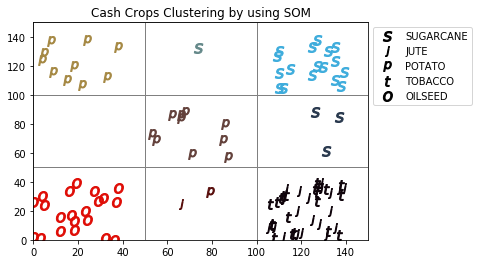

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches as patches
import matplotlib.lines as mlines

fig = plt.figure()
# setup axes
ax = fig.add_subplot(111)
scale = 50
ax.set_xlim((0, som.net.shape[0]*scale))
ax.set_ylim((0, som.net.shape[1]*scale))
ax.set_title("Cash Crops Clustering by using SOM")

for x in range(0, som.net.shape[0]):
    for y in range(0, som.net.shape[1]):
        ax.add_patch(patches.Rectangle((x*scale, y*scale), scale, scale,
                     facecolor='white',
                     edgecolor='grey'))
legend_map = {}
        
for row in prediction.collect():
    x_cor = row['bmu_idx'][0] * scale
    y_cor = row['bmu_idx'][1] * scale
    x_cor = np.random.randint(x_cor*1.05, (x_cor + scale*0.8))
    y_cor = np.random.randint(y_cor*1.05, (y_cor + scale*0.8))
    color = row['bmu']
    marker = "$\\ " + row['Crop'][0]+"$"
    marker = marker.lower()
    ax.plot(x_cor, y_cor, color=color, marker=marker, markersize=10)
    label = row['Crop']
    if not label in legend_map:
        legend_map[label] =  mlines.Line2D([], [], color='black', marker=marker, linestyle='None',
                          markersize=10, label=label)
plt.legend(handles=list(legend_map.values()), bbox_to_anchor=(1, 1))
plt.show()

It can be seen from the visualization above that the data has been clustered quite nicely. Moreover, the clustering is similar to SOM1.ipynb. So, we have verified our Apache Spark Implementation of SOM Batch Algorithm.